ここでは、[pandaset](https://scale.com/open-datasets/pandaset)というデータセットを扱っていく。    
データを上記のリンク先から、本リポジトリの`data/`の配下にダウンロードしてほしい。  
Pandasetのダウンロードは、Download Part1 ~ Part3に分かれているが、今回はPart1のみ扱う予定である。  
Part1だけでも約16Gあるので、ダウンロードに時間がかかる点は注意されたい。  
`pandaset_0.zip`を展開すると、`001` ~ `047`のディレクトリで構成されている。例えば、`001`は以下のようなファイル構成となっている。    

```
001/
├── LICENSE.txt
├── annotations
│   ├── cuboids
│   │   ├── 00.pkl.gz
│   │   .
│   │   .
│   │   .
│   │   └── 79.pkl.gz
│   └── semseg  // Semantic Segmentation is available for specific scenes
│       ├── 00.pkl.gz
│       .
│       .
│       .
│       ├── 79.pkl.gz
│       └── classes.json
├── camera
│   ├── back_camera
│   │   ├── 00.jpg
│   │   .
│   │   .
│   │   .
│   │   ├── 79.jpg
│   │   ├── intrinsics.json
│   │   ├── poses.json
│   │   └── timestamps.json
│   ├── front_camera
│   │   └── ...
│   ├── front_left_camera
│   │   └── ...
│   ├── front_right_camera
│   │   └── ...
│   ├── left_camera
│   │   └── ...
│   └── right_camera
│       └── ...
├── lidar
│   ├── 00.pkl.gz
│   .
│   .
│   .
│   ├── 79.pkl.gz
│   ├── poses.json
│   └── timestamps.json
└── meta
    ├── gps.json
    └── timestamps.json
```

ここでは、データを１つずつ確認する

In [26]:
!python --version

Python 3.7.12


In [27]:
from glob import glob
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# image

カメラで撮影されたRGB画像である。

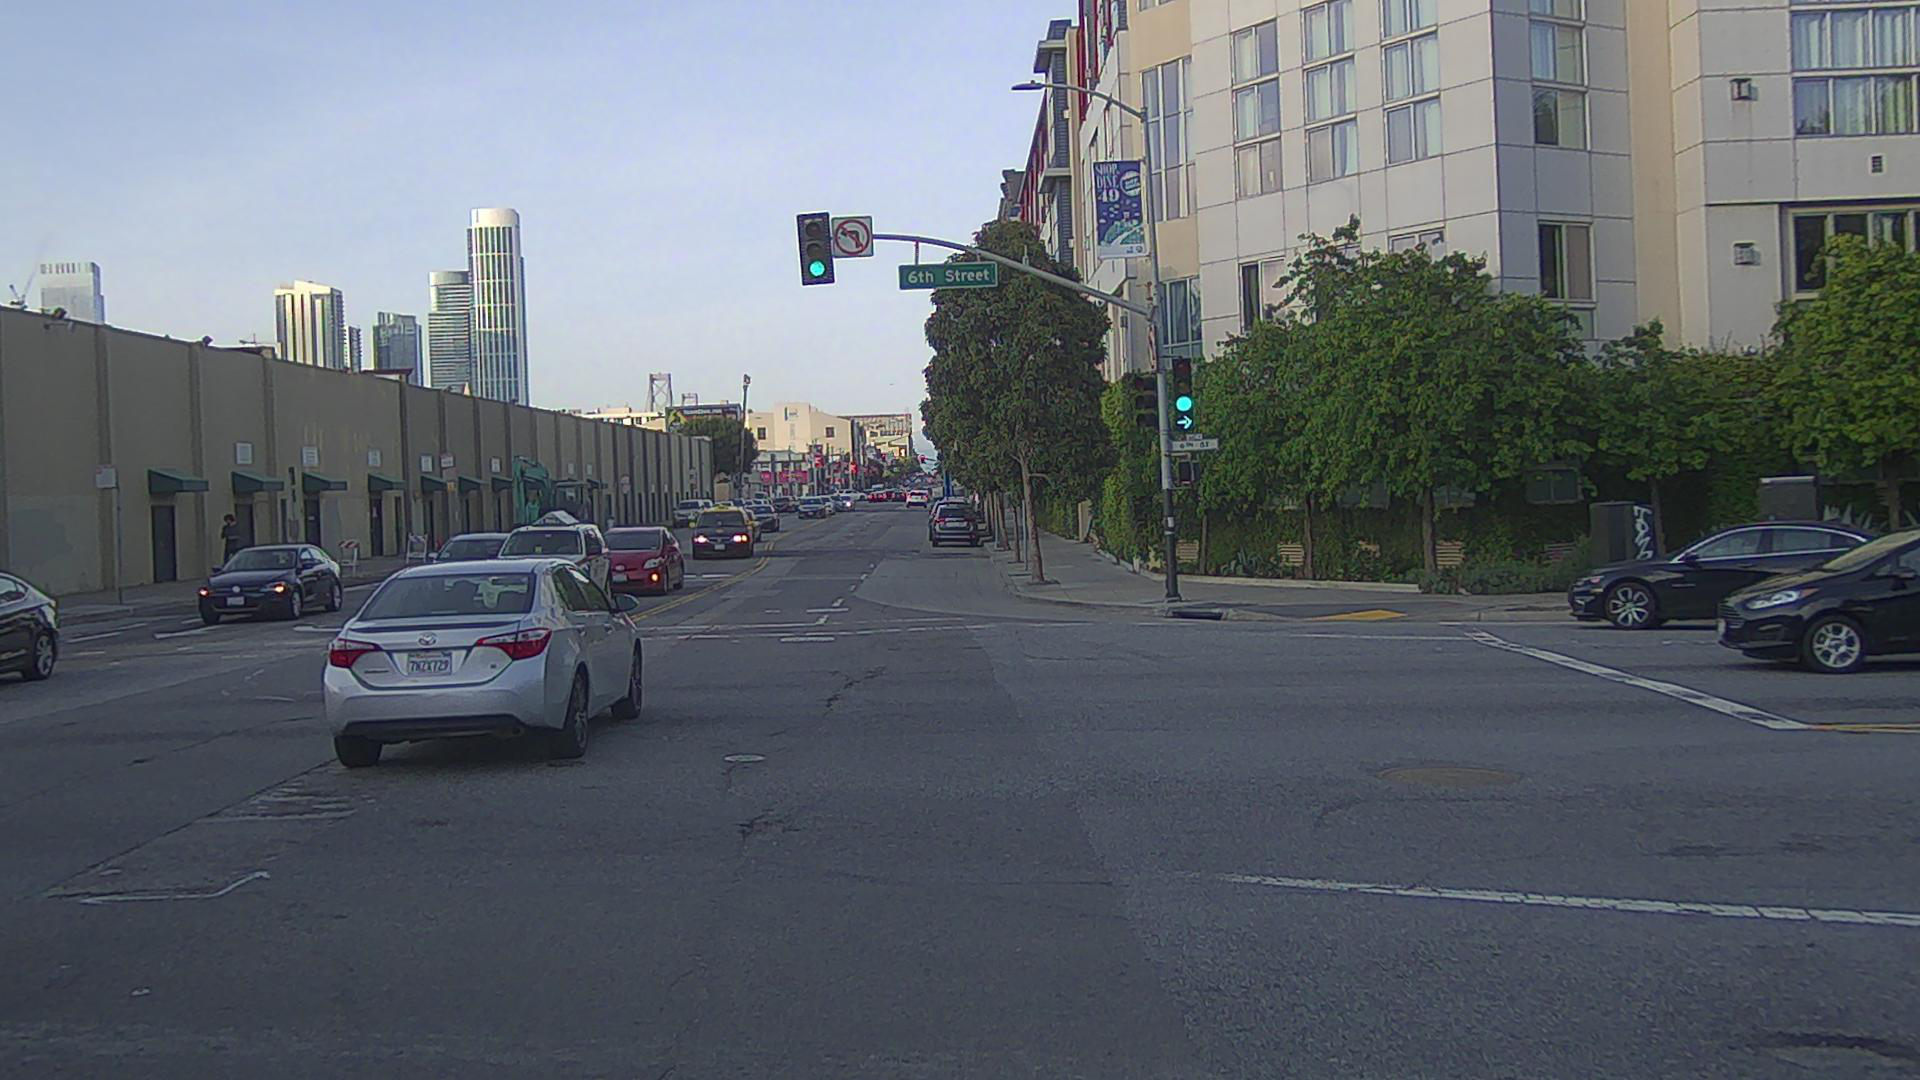

In [34]:
img_dir_num = 1
camera_type = "front_camera"
show_idx = 0

img_path = glob(f"../data/{img_dir_num:03d}/camera/{camera_type}/*.jpg")[show_idx]

pil_img = Image.open(img_path)
pil_img

In [73]:
img_array = np.array(pil_img)
print("img shape: ", img_array.shape)
print(np.min(img_array), np.max(img_array))
print(img_array.dtype)

img shape:  (1080, 1920, 3)
0 255
uint8


# intrinsics.json

カメラの内部パラメータがjson形式で保存されている。  
カメラの内部パラメータは、カメラによって決まるものであり、カメラ座標にカメラの内部パラメータからなる行列（内部パラメータ行列）をかけることによって、カメラ座標を画像座標に投影することができる。  
[カメラ内部パラメータとは？](https://mem-archive.com/2018/02/21/post-157/)

In [36]:
import json

intrinsics_path = f"../data/{img_dir_num:03d}/camera/{camera_type}/intrinsics.json"
with open(intrinsics_path, "r") as f:
    intrinsics = json.load(f)

In [37]:
print(intrinsics)

{'fx': 1970.0131, 'fy': 1970.0091, 'cx': 970.0002, 'cy': 483.2988}


# camera: pose.json

カメラの取り付け角度位置を表す。カメラの位置がワールド座標で、姿勢が[クォータニオン](https://qiita.com/arisen/items/7b7e51777ef83c2e49af)で保存されている。

In [74]:
camera_pose_path = f"../data/{img_dir_num:03d}/camera/{camera_type}/poses.json"
with open(camera_pose_path, "r") as f:
    camera_poses = json.load(f)

In [21]:
print(len(camera_poses))
camera_poses[img_dir_num]

80


{'position': {'x': 0.949616007909577,
  'y': 0.8101681919803494,
  'z': 1.8218365767094171},
 'heading': {'w': 0.6584078044422097,
  'x': -0.6473552920891482,
  'y': 0.28054678334854116,
  'z': -0.262152229070342}}

A pose dictionary of the Camera sensor in world-coordinates for each frame. The dictionary keys return the following types:
- `position`: `dict`
  - `x`: `float`
    - Position of Camera sensor in world-coordinate system (x-axis) in meter
  - `y`: `float`
    - Position of Camera sensor in world-coordinate system (y-axis) in meter
  - `z`: `float`
     - Position of Camera sensor in world-coordinate system (z-axis) in meter
- `heading`: `dict`
  - `w`: `float`
    - Real part of _Quaternion_
  - `x`: `float`
    - First imaginary part of _Quaternion_
  - `y`: `float`
    - Second imaginary part of _Quaternion_
  - `z`: `float`
    - Third imaginary part of _Quaternion_

# camera: timestamps.json

カメラセンサーのtimestampが保存されている。

In [42]:
camera_timestamp_path = f"../data/{img_dir_num:03d}/camera/{camera_type}/timestamps.json"
with open(camera_timestamp_path, "r") as f:
    camera_timestamps = json.load(f)

In [46]:
print(len(camera_timestamps))
print(camera_timestamps[:10])

80
[1557539924.449972, 1557539924.54996, 1557539924.649934, 1557539924.749918, 1557539924.849951, 1557539924.950014, 1557539925.050046, 1557539925.150056, 1557539925.250073, 1557539925.350082]


# lidar

LiDARセンサーで測定したポイントクラウドの情報がデータフレーム形式で保存されている。  [LiDARとは？](https://www.rohm.co.jp/electronics-basics/laser-diodes/ld_what10)  

In [48]:
import gzip
import pickle

lidar_path = f"../data/{img_dir_num:03d}/lidar/{show_idx:02d}.pkl.gz"

with gzip.open(lidar_path, "r") as f:
    lidar = pickle.load(f)

In [59]:
print(len(lidar))
print(lidar.head())
print()
print(lidar.info())

169171
               x          y         z     i             t  d
index                                                       
0     -58.457199 -61.269268  2.881014  39.0  1.557540e+09  0
1     -71.572182 -74.840317  1.279183   9.0  1.557540e+09  0
2     -42.442833 -44.357426  0.426503  56.0  1.557540e+09  0
3     -31.749357 -33.156342 -0.025245   3.0  1.557540e+09  0
4      -9.920758 -10.442794  1.010120   0.0  1.557540e+09  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169171 entries, 0 to 169170
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       169171 non-null  float64
 1   y       169171 non-null  float64
 2   z       169171 non-null  float64
 3   i       169171 non-null  float64
 4   t       169171 non-null  float64
 5   d       169171 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 7.7 MB
None


List of point cloud data frames for each timestamp. Each data frame has columns as follows:
- index: `int`
  - Ordered point cloud. When joining the raw point cloud with data from ``SemanticSegmentation``, it is important to keep the index order.
- `x`: `float`  
  - Position of point in world-coordinate system (x-axis) in meter
- `y`: `float`
  - Position of point in world-coordinate system (y-axis) in meter
- `z`: `float`
  - Position of point in world-coordinate system (z-axis) in meter
- `i`: `float`
  - Reflection intensity in a range `[0,255]`
- `t`: `float`
  - Recorded timestamp for specific point
- `d`: `int`
  - Sensor ID. `0` -> mechnical 360° LiDAR, `1` -> forward-facing LiDAR

# lidar: poses.json 

LiDARセンサーの位置がワールド座標で、姿勢がクォータニオンで保存されている。

In [60]:
lidar_pose_path = f"../data/{img_dir_num:03d}/lidar/poses.json"
with open(lidar_pose_path, "r") as f:
    lidar_poses = json.load(f)

In [62]:
print(len(lidar_poses))
lidar_poses[img_dir_num]

80


{'position': {'x': 0.5567106077665928,
  'y': 0.5506659726750831,
  'z': 0.008819164477798357},
 'heading': {'w': 0.9223153982060285,
  'x': 0.010172188957944597,
  'y': 0.020377226369147156,
  'z': -0.3857662523463648}}

A pose dictionary of the LiDAR sensor in world-coordinates for each frame. The dictionary keys return the following types:
- `position`: `dict`
  - `x`: `float`
    - Position of LiDAR sensor in world-coordinate system (x-axis) in meter
  - `y`: `float`
    - Position of LiDAR sensor in world-coordinate system (y-axis) in meter
  - `z`: `float`
     - Position of LiDAR sensor in world-coordinate system (z-axis) in meter
- `heading`: `dict`
  - `w`: `float`
    - Real part of _Quaternion_
  - `x`: `float`
    - First imaginary part of _Quaternion_
  - `y`: `float`
    - Second imaginary part of _Quaternion_
  - `z`: `float`
    - Third imaginary part of _Quaternion_
    
LiDARセンサーの座標がワールド座標で、姿勢がクォータニオンで保存されている。

In [75]:
#T.B.D